In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
## Import up sound alert dependencies
from IPython.display import Audio, display

def allDone():
    display(Audio(filename='/home/saqib/Downloads/woo_vu_luvub_dub_dub.wav', autoplay=True))

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sn
from pylab import rcParams

In [4]:
rcParams['figure.figsize'] = 18, 10
sn.set_style('darkgrid')

In [5]:
from fastai import conv_learner
from fastai import dataloader
from fastai import dataset
from fastai import core
from fastai import transforms

## Test Submission File Creation

In [6]:
# Convert class ids (0, 1, 2...) to class names (Abstract, Biker etc)
def classes_to_names(pred_classes, class_names, datapoints):
    matrix = list()
    for i, pclass in enumerate(pred_classes):
        matrix.append([datapoints[i], class_names[pclass]])
    return matrix

In [7]:
# Convert class ids (0, 1, 2...) to class names (Abstract, Biker etc)
# Also append the likelihoods of each class to the end so that they
# can be used for creating new models (stacking, ensembling)
def create_submission_single_fill(predictions, class_names, filenames, filler, 
                                  output_filename):
    # Convert log likelihoods to likelihoods
    likelihoods = np.exp(predictions)
    # Take the class with the highest likelihood
    pred_classes = np.argmax(likelihoods, axis=1)
    # Convert class ids to class names 
    matrix = classes_to_names(pred_classes, class_names, filenames)
    mat2 = list(map(lambda x: [x[0][5:], x[1]], matrix))
    # Create a prediction column for each filename (obtained after preprocessing CSVs)
    matrix_df = pd.DataFrame(mat2, columns=['filename', 'prediction'])
    # Load the preprocessed CSV, which contains filenames for matching
    test_df = pd.read_csv('data/Submission_online_fnames.csv')
    # Take a left join on the dataframes to fill in the values predicted
    final = test_df.merge(matrix_df, on='filename', how='left')
    # Fill in the missing ones with the majority class
    final['prediction'] = final['prediction'].fillna('Solid')
    final.to_csv(output_filename, index=False)
    print('Saved to {}'.format(output_filename))

In [8]:
# Same as the function above. Just assumes that instead of log likelihoods,
# It gets likelihoods
def create_submission_single_fill_2(likelihoods, class_names, filenames, filler, 
                                  output_filename):
#     likelihoods = np.exp(predictions)
    pred_classes = np.argmax(likelihoods, axis=1)
    matrix = classes_to_names(pred_classes, class_names, filenames)
    mat2 = list(map(lambda x: [x[0][5:], x[1]], matrix))
    matrix_df = pd.DataFrame(mat2, columns=['filename', 'prediction'])
    test_df = pd.read_csv('data/Submission_online_fnames.csv')
    final = test_df.merge(matrix_df, on='filename', how='left')
    final['prediction'] = final['prediction'].fillna('Solid')
    final.to_csv(output_filename, index=False)
    print('Saved to {}'.format(output_filename))

In [5]:
sz = 224 # Images will be resized to 224 X 224 before using as Neural Net's inputs
path = 'data/images_train/' # Path of training data

In [6]:
# Using Resnet-50 for experimentation 
arch = core.resnet34

In [16]:
## Get a learner object to train the ResNet-34 model
arch = core.resnet34
# Get a Dataset object (which encapsulates a PyTorch data object)
data = dataset.ImageClassifierData.from_paths(path, # data path 
                                              bs=64, # batch size
                                              tfms=transforms.tfms_from_model(arch, sz) # Images will be transformed accoring to the model
                                             )
# Finally get a convolutional learner object
learner = conv_learner.ConvLearner.pretrained(arch, # Resnet-34
                                              data, # Dataset object 
                                              precompute=True # Use precomputed activations of the pre-trained ResNet-50
                                             )

In [17]:
# Try training the convolutional network with a random learning rate
learner.fit(0.01, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      1.39537    1.219518   0.647793  
    1      1.27382    1.17727    0.657971                   



[1.17727, 0.6579711960686236]

In [18]:
# Use precomputed activations to determine the optimal learning rate
learner = conv_learner.ConvLearner.pretrained(arch, data, precompute=True)
# This finds the learning rate using the technique in Leslie Smith's cyclical learning rates paper of 2015
lrf = learner.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 84%|████████▎ | 734/879 [00:08<00:01, 88.69it/s, loss=6.77]


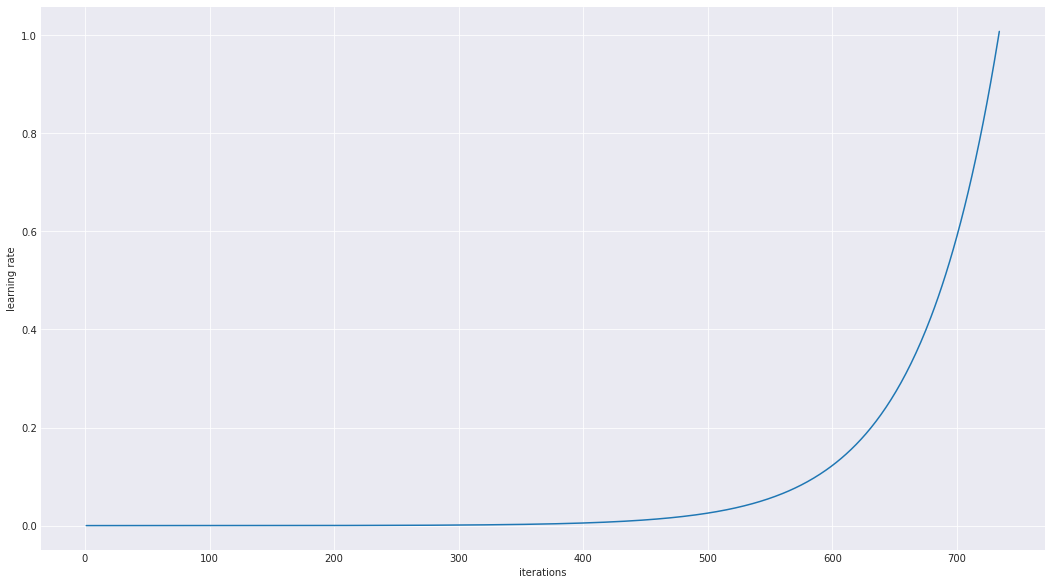

In [19]:
learner.sched.plot_lr()

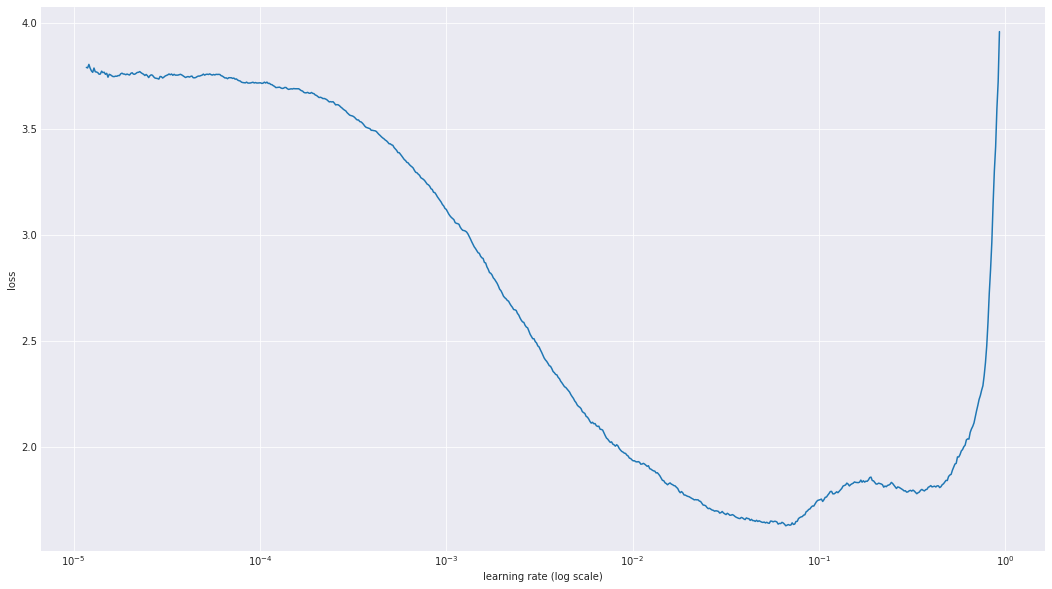

In [20]:
# The idea is to choose the learning rate at which the loss decrease is the steepest
# It doesn't have to be exact. A good enough approximation will do.
# We use 5e-2 (0.05) as our learning rate

learner.sched.plot() # plot the learning rate against the loss

In [7]:
# Data augmentation on the images
trans = transforms.tfms_from_model(arch, # Resnet-34
                                   sz, # 224 
                                   aug_tfms=transforms.transforms_side_on, # Performs small rotations, changes in brighness and random horizontal flips 
                                   max_zoom=1.15)

In [22]:
def get_augs():
    data = conv_learner.ImageClassifierData.from_paths(path, bs=2, 
                                                       tfms=trans, num_workers=1)
    x, _ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [23]:
ims = np.stack([get_augs() for i in range(6)])

In [24]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

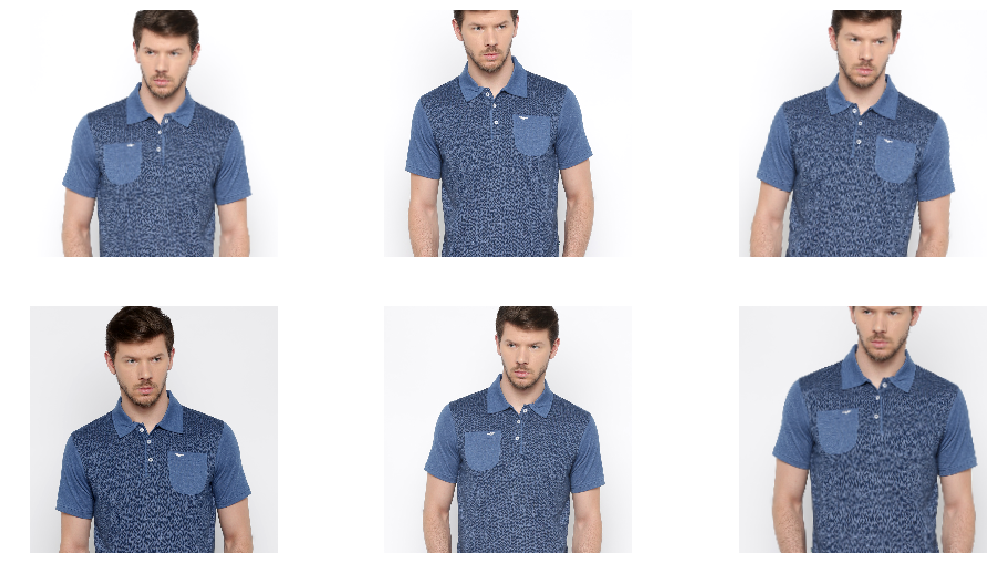

In [25]:
plots(ims, figsize=(18, 10), rows=2)

In [26]:
data = conv_learner.ImageClassifierData.from_paths(path, bs=64, tfms=trans)
learner = conv_learner.ConvLearner.pretrained(arch, data, precompute=True)

In [27]:
# Fit with the learning rate determined from LR find
# All the layers except the last one are frozen
learner.fit(0.005, 3)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      1.397872   1.24929    0.639981  
    1      1.315339   1.197865   0.653446                   
    2      1.272534   1.171341   0.658988                   



[1.1713408, 0.6589884020618557]

In [28]:
# Don't use the precomputed activations
learner.precompute = False

In [29]:
learner.fit(0.005, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      1.285587   1.171532   0.658666  
    1      1.25962    1.166966   0.65699                    
    2      1.279264   1.161961   0.65699                     



[1.1619613, 0.6569897861786417]

In [32]:
learner.save('models/resnet-34-1')

FileNotFoundError: [Errno 2] No such file or directory: 'data/images_train/models/models/resnet-34-1.h5'

In [33]:
# Finetuning and differential rate annealing
learner.unfreeze()

In [34]:
# Use weights increasing in a geometrical progression to train the network
# The earlier layers need less finetuning since they learn to recognize low-level (simpler)
# features. The later layers learn more complex features and need to be finetuned more
# The entire network is divided into three layer groups and each layer group is finetuned
# using the same learning rate.
lrs = np.array([0.00125, 0.0025, 0.0050])

In [35]:
# Train the neural network for three cycles
# cycle_len=1 means reset the the learning rate after every epoch (the learning rate 
# is decresed for every data point using Cosine Annealing)
# cycle_mult=2 means reset the learning rate in a multiple of two epoch (uses
# cycle_len as the base and keeps resetting the learning rate after 1, 2, 4... epochs)
# This is an implementation of Stochastic Gradient Descent with Restarts (SGDR)
learner.fit(lrs, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      1.057195   1.002645   0.700023  
    1      0.993131   0.964475   0.712566                    
    2      0.924004   0.920677   0.722276                     
    3      0.938482   0.923894   0.724451                     
    4      0.85942    0.886889   0.73618                      
    5      0.7851     0.862626   0.744726                     
    6      0.73117    0.863258   0.743548                     



[0.8632579, 0.7435477520387197]

In [36]:
learner.save('resnet-34-diff-anneal-1')

All of the stuff from here on, which is used to create a submission file has
been moved into helper functions in the beginning of the notebook

In [38]:
from torch.utils.data import DataLoader

In [9]:
test_data = dataset.ImageClassifierData.from_paths(path, 64, test_name='test', tfms=trans)

In [10]:
test_dl = test_data.test_dl

In [10]:
learner = conv_learner.ConvLearner.pretrained(arch, test_data)

In [14]:
learner.load('resnet-34-diff-anneal-1')

In [15]:
predictions = learner.predict_dl(test_dl)

In [17]:
predictions.shape

(14712, 24)

In [22]:
likelihoods = np.exp(predictions)

In [25]:
np.argmax(likelihoods[:10], axis=1)

array([ 8, 15, 12, 22,  5, 10, 22, 10,  7, 16])

In [27]:
pred_classes = np.argmax(likelihoods, axis=1)

In [19]:
def class_to_names(pred_classes, class_names, datapoints):
    matrix = list()
    for i, pclass in enumerate(pred_classes):
        matrix.append([datapoints[i], class_names[pclass]])
    return matrix

In [31]:
matrix = class_to_names(pred_classes, test_data.classes, test_data.test_ds.fnames)

In [36]:
mat2 = list(map(lambda x: [x[0][5:], x[1]], matrix))

In [37]:
matrix[:5]

[['test/0659ce29-0fc2-47c2-9866-f87e95bc84d4default.jpg', 'Graphic'],
 ['test/0883d9eb-f9f0-4bc8-a76b-53b83e41defddefault.jpg', 'Solid'],
 ['test/08b832f5-0f28-487c-916e-24222b3ecc5cdefault.jpg', 'People and Places'],
 ['test/08bbc759fa1e34d1cae5173e0e896bf5_images.jpg', 'Typography'],
 ['test/1%2C1.jpg?dl=1', 'Conversational']]

In [38]:
mat2[:5]

[['0659ce29-0fc2-47c2-9866-f87e95bc84d4default.jpg', 'Graphic'],
 ['0883d9eb-f9f0-4bc8-a76b-53b83e41defddefault.jpg', 'Solid'],
 ['08b832f5-0f28-487c-916e-24222b3ecc5cdefault.jpg', 'People and Places'],
 ['08bbc759fa1e34d1cae5173e0e896bf5_images.jpg', 'Typography'],
 ['1%2C1.jpg?dl=1', 'Conversational']]

In [39]:
test_df = pd.read_csv('data/Submission_online_fnames.csv')

In [40]:
test_df.head()

,Brand,Category,Gender,Color,Link_to_the_image,Sub_category,filename
0,Allen Solly,Tshirts,Men,Red,http://myntra.myntassets.com/assets/images/182...,NaN,11490680940727-Allen-Solly-Men-Red-Solid-Round...
1,Celio,Tshirts,Men,Yellow,http://myntra.myntassets.com/assets/images/109...,NaN,11475223023888-Celio-Men-Yellow-Solid-V-Neck-T...
2,CULT FICTION,Tshirts,Men,Rust,http://myntra.myntassets.com/assets/images/159...,NaN,11480419683787-CULT-FICTION-Men-Rust-Solid-Rou...
3,Antigravity,Tshirts,Women,Blue,http://myntra.myntassets.com/assets/images/185...,NaN,11493204669821-Antigravity-Women-Blue-Printed-...
4,Being Human,Tshirts,Men,Charcoal,http://myntra.myntassets.com/assets/images/100...,NaN,11468221198445-Being-Human-Clothing-Charcoal-G...


In [43]:
mat_df = pd.DataFrame(mat2, columns=['filename', 'prediction'])

In [44]:
mat_df.head()

,filename,prediction
0,0659ce29-0fc2-47c2-9866-f87e95bc84d4default.jpg,Graphic
1,0883d9eb-f9f0-4bc8-a76b-53b83e41defddefault.jpg,Solid
2,08b832f5-0f28-487c-916e-24222b3ecc5cdefault.jpg,People and Places
3,08bbc759fa1e34d1cae5173e0e896bf5_images.jpg,Typography
4,1%2C1.jpg?dl=1,Conversational


In [45]:
final = test_df.merge(mat_df, on='filename', how='left')

In [46]:
final.head()

,Brand,Category,Gender,Color,Link_to_the_image,Sub_category,filename,prediction
0,Allen Solly,Tshirts,Men,Red,http://myntra.myntassets.com/assets/images/182...,NaN,11490680940727-Allen-Solly-Men-Red-Solid-Round...,Solid
1,Celio,Tshirts,Men,Yellow,http://myntra.myntassets.com/assets/images/109...,NaN,11475223023888-Celio-Men-Yellow-Solid-V-Neck-T...,Solid
2,CULT FICTION,Tshirts,Men,Rust,http://myntra.myntassets.com/assets/images/159...,NaN,11480419683787-CULT-FICTION-Men-Rust-Solid-Rou...,Solid
3,Antigravity,Tshirts,Women,Blue,http://myntra.myntassets.com/assets/images/185...,NaN,11493204669821-Antigravity-Women-Blue-Printed-...,Typography
4,Being Human,Tshirts,Men,Charcoal,http://myntra.myntassets.com/assets/images/100...,NaN,11468221198445-Being-Human-Clothing-Charcoal-G...,Typography


In [ ]:
final['prediction'] = final['prediction'].fillna('Solid')

In [57]:
final.to_csv('submission-01.csv', index=False)

In [49]:
from collections import Counter

In [50]:
# Find the majority class predicted
counter = Counter(pred_classes)

In [51]:
counter

Counter({0: 221,
         1: 50,
         2: 59,
         3: 31,
         4: 552,
         5: 190,
         6: 293,
         7: 418,
         8: 758,
         10: 195,
         11: 2,
         12: 232,
         14: 4,
         15: 5531,
         16: 31,
         17: 52,
         18: 2334,
         19: 131,
         20: 48,
         21: 9,
         22: 3490,
         23: 81})

In [52]:
test_data.classes[15]

'Solid'

,Brand,Category,Gender,Color,Link_to_the_image,Sub_category,filename,prediction
0,Allen Solly,Tshirts,Men,Red,http://myntra.myntassets.com/assets/images/182...,NaN,11490680940727-Allen-Solly-Men-Red-Solid-Round...,Solid
1,Celio,Tshirts,Men,Yellow,http://myntra.myntassets.com/assets/images/109...,NaN,11475223023888-Celio-Men-Yellow-Solid-V-Neck-T...,Solid
2,CULT FICTION,Tshirts,Men,Rust,http://myntra.myntassets.com/assets/images/159...,NaN,11480419683787-CULT-FICTION-Men-Rust-Solid-Rou...,Solid
3,Antigravity,Tshirts,Women,Blue,http://myntra.myntassets.com/assets/images/185...,NaN,11493204669821-Antigravity-Women-Blue-Printed-...,Typography
4,Being Human,Tshirts,Men,Charcoal,http://myntra.myntassets.com/assets/images/100...,NaN,11468221198445-Being-Human-Clothing-Charcoal-G...,Typography


## Finetuning the Network Further

In [58]:
# Finetuning and differential rate annealing
learner.unfreeze()

In [59]:
lrs = np.array([0.00125, 0.0025, 0.0050])

In [60]:
learner.fit(lrs, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.779398   0.86467    0.743005  
    1      0.754696   0.871539   0.742199                    
    2      0.679605   0.85866    0.746271                    
    3      0.766952   0.904716   0.739592                    
    4      0.671754   0.871991   0.748416                    
    5      0.583859   0.873524   0.751044                    
    6      0.505866   0.872289   0.753541                     



[0.87228906, 0.753540831435587]

In [61]:
learner.save('resnet-34-finetuned-2')

In [11]:
learner.load('resnet-34-finetuned-2')

In [12]:
predictions = learner.predict_dl(test_data.test_dl)

In [14]:
likelihoods = np.exp(predictions)

In [17]:
pred_classes = np.argmax(likelihoods, axis=1)

In [20]:
matrix = class_to_names(pred_classes, test_data.classes, test_data.test_ds.fnames)

In [22]:
mat2 = list(map(lambda x: [x[0][5:], x[1]], matrix))

In [23]:
test_df = pd.read_csv('data/Submission_online_fnames.csv')
mat_df = pd.DataFrame(mat2, columns=['filename', 'prediction'])
final = test_df.merge(mat_df, on='filename', how='left')

In [24]:
from collections import Counter

In [25]:
counter = Counter(pred_classes)

In [26]:
counter

Counter({0: 331,
         1: 38,
         2: 57,
         3: 32,
         4: 544,
         5: 183,
         6: 255,
         7: 470,
         8: 864,
         10: 180,
         11: 13,
         12: 220,
         13: 3,
         14: 10,
         15: 5496,
         16: 60,
         17: 68,
         18: 2299,
         19: 141,
         20: 39,
         21: 15,
         22: 3301,
         23: 93})

In [28]:
final['prediction'] = final['prediction'].fillna('Solid')
final.to_csv('submission-02.csv', index=False)

## Finetuning v2. Use less epochs. Change the transformations

In [12]:
# Change the zoom level to get slightly more different augmentations
trans = transforms.tfms_from_model(arch, sz, aug_tfms=transforms.transforms_side_on, 
                                        max_zoom=1.20)

In [13]:
test_data = conv_learner.ImageClassifierData.from_paths('data/images_train/', bs=64, tfms=trans, test_name='test')

In [14]:
learner = conv_learner.ConvLearner.pretrained(arch, test_data)

In [15]:
learner.load('resnet-34-diff-anneal-1')

In [16]:
learner.unfreeze()

In [17]:
learner.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 79%|███████▊  | 691/879 [34:50<09:28,  3.02s/it, loss=2.73]  

In [33]:
learner.sched.plot_lr()

In [36]:
learner.sched.plot()

In [37]:
learner.sched.plot_loss()

In [38]:
# We will use 1e-4 as the new learning rate as indicated (in the invisible graph)

In [46]:
learner.load('resnet-34-diff-anneal-1')

In [47]:
type(learner)

fastai.conv_learner.ConvLearner

In [48]:
lrs = np.array([0.25e-4, 0.5e-4, 1e-4])

In [49]:
learner.fit(lrs, 3, cycle_len=1, cycle_mult=2, 
            cycle_save_name='resnet-34-diff-anneal-1_lr-1e-4')
allDone()

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.753259   0.864078   0.745642  
    1      0.717427   0.859876   0.746256                     
    2      0.702886   0.861137   0.745466                    
    3      0.709115   0.860938   0.744565                    
    4      0.711332   0.860127   0.744968                    
    5      0.700187   0.859396   0.745305                    
    6      0.721672   0.864006   0.744887                    



In [55]:
learner.load('resnet-34-diff-anneal-1_lr-1e-4_cyc_0')
predictions = learner.predict_dl(test_data.test_dl)

In [63]:
create_submission_single_fill(predictions, test_data.classes, test_data.test_ds.fnames, 
                              'Solid', 'resnet-34-diff-anneal-1_lr-1e-4_cyc_0.csv')

Saved to resnet-34-diff-anneal-1_lr-1e-4_cyc_0.csv


In [77]:
tta_test = learner.TTA(is_test=True)
allDone()

In [79]:
logits, y = tta_test

In [86]:
create_submission_single_fill_2(np.mean(np.exp(logits), 0), test_data.classes, test_data.test_ds.fnames, 
                                'Solid', 'resnet-34-diff-anneal-1_lr-1e-4_cyc_0-tta.csv')

Saved to resnet-34-diff-anneal-1_lr-1e-4_cyc_0-tta.csv


In [87]:
# TTA with 8 augmentations
tta_test = learner.TTA(n_aug=8, is_test=True)
allDone()

In [88]:
logits, y = tta_test

In [89]:
create_submission_single_fill_2(np.mean(np.exp(logits), 0), test_data.classes, test_data.test_ds.fnames, 
                                'Solid', 'resnet-34-diff-anneal-1_lr-1e-4_cyc_0-tta-8augs.csv')

Saved to resnet-34-diff-anneal-1_lr-1e-4_cyc_0-tta-8augs.csv


## Training The Network on Smaller Images
Training on smaller images will regularize the network. Hence, we now train on smaller images

In [6]:
sz = 224 # But before making the images smaller, we need to load the pretrained weights
         # for images of size 224 X 224. 
arch = core.resnet34
trans = transforms.tfms_from_model(arch, sz, aug_tfms=transforms.transforms_side_on, 
                                        max_zoom=1.20)

In [7]:
test_data = conv_learner.ImageClassifierData.from_paths('data/images_train/', bs=64, tfms=trans, test_name='test')

In [8]:
learner = conv_learner.ConvLearner.pretrained(arch, test_data)
learner.load('resnet-34-diff-anneal-1_lr-1e-4_cyc_0')

In [9]:
# Now, train the network on 128 X 128 sized images.
trans = transforms.tfms_from_model(arch, 128, aug_tfms=transforms.transforms_side_on, 
                                        max_zoom=1.20)
test_data = conv_learner.ImageClassifierData.from_paths('data/images_train/', bs=64, tfms=trans, test_name='test')

In [17]:
first = next(iter(test_data_2.aug_dl))

In [10]:
learner.set_data(test_data)

Everything from this point is a re-iteration of the previous steps.
1. Train the last layer of the network by freezing all other layers
2. Unfreeze the network and and use differential rate annealing (Cosine Annealing + SGDR)
3. Train the network again and again until it overfits, then change the input image size, as a regularization step and repeat

In [11]:
learner.freeze()

In [12]:
lrs = np.array([0.25e-4, 0.5e-4, 1e-4])
learner.fit(lrs, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      1.091415   1.15147    0.67212   
    1      1.068925   1.134023   0.677224                   
    2      1.064404   1.130665   0.676499                   
    3      1.083714   1.122719   0.677868                   
    4      1.097305   1.11826    0.678643                   
    5      1.052922   1.119665   0.677838                   
    6      1.082277   1.115647   0.679852                   



[1.1156474, 0.6798515654716295]

In [13]:
learner.unfreeze()
lrs = np.array([1e-4 / 9.0, 1e-4 / 3.0, 1e-4])
learner.fit(lrs, 2, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      1.104281   1.134036   0.672185  
    1      1.046779   1.098758   0.680752                   
    2      1.07643    1.089797   0.68486                    



[1.0897975, 0.684860037236484]

In [14]:
learner.fit(lrs, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      1.058817   1.083316   0.685006  
    1      1.023651   1.065824   0.688756                    
    2      1.022643   1.068417   0.687664                    
    3      0.995997   1.050555   0.691414                    


KeyboardInterrupt: 

In [15]:
learner.save('resnet-34-diff-anneal-128pix')

In [11]:
learner.load('resnet-34-diff-anneal-128pix')
learner.unfreeze()

In [12]:
learner.fit(, 1, cycle_len=3)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      1.013503   1.039478   0.694489  
    1      0.999811   1.033133   0.696064                    
    2      0.994671   1.039959   0.694248                    



[1.0399587, 0.6942475659331095]

In [13]:
allDone()

In [14]:
learner.save('resnet-34-diff-anneal-128pix-latest')

## Train on Large Images
Further regularize the network on training on large images

In [8]:
sz = 224
arch = core.resnet34
trans = transforms.tfms_from_model(arch, sz, aug_tfms=transforms.transforms_side_on, 
                                        max_zoom=1.20)
test_data = conv_learner.ImageClassifierData.from_paths('data/images_train/', bs=64, tfms=trans, test_name='test')
learner = conv_learner.ConvLearner.pretrained(arch, test_data)
learner.load('resnet-34-diff-anneal-128pix-latest')

In [9]:
arch = core.resnet34
trans = transforms.tfms_from_model(arch, 299, aug_tfms=transforms.transforms_side_on, 
                                        max_zoom=1.20)
test_data = conv_learner.ImageClassifierData.from_paths('data/images_train/', bs=64, tfms=trans, test_name='test')

In [10]:
learner.set_data(test_data)

In [10]:
learner.freeze()

In [11]:
lrs = np.array([1e-4 / 9.0, 1e-4 / 3.0, 1e-4])
learner.fit(lrs, 3, cycle_len=1, cycle_mult=2, cycle_save_name='resnet-34-diff-anneal-299pix')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.94393    0.966258   0.713703  
    1      0.914623   0.952812   0.717942                    
    2      0.911316   0.950028   0.718183                    
    3      0.894405   0.948069   0.719779                    
    4      0.909848   0.939566   0.720358                    
    5      0.92261    0.941298   0.721647                    
    6      0.888593   0.941292   0.721229                    



[0.94129175, 0.7212288803660992]

In [9]:
arch = core.resnet34
trans = transforms.tfms_from_model(arch, 299, aug_tfms=transforms.transforms_side_on, 
                                        max_zoom=1.20)
test_data = conv_learner.ImageClassifierData.from_paths('data/images_train/', bs=16, tfms=trans, test_name='test')
learner = conv_learner.ConvLearner.pretrained(arch, test_data)
learner.load('resnet-34-diff-anneal-299pix_cyc_2')
learner.unfreeze()
lrs = np.array([1e-4 / 9.0, 1e-4 / 3.0, 1e-4])
# learner.fit(lrs, 3, cycle_len=1, cycle_mult=2, cycle_save_name='resnet-34-diff-anneal-299pix-unfrozen')

In [10]:
learner.load('resnet-34-diff-anneal-299pix-unfrozen_cyc_1')

In [10]:
learner.fit(lrs, 3, cycle_len=4, cycle_save_name='resnet-34-diff-anneal-299pix-unfrozen-2')

HBox(children=(IntProgress(value=0, description='Epoch', max=12), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                      
    0      0.847199   0.847695   0.744228  
    1      0.879733   0.842358   0.746805                      
    2      0.839108   0.840762   0.748497                      
    3      0.810366   0.83915    0.74906                       
    4      0.832868   0.840666   0.748255                      
    5      0.808871   0.841933   0.747933                      
    6      0.767097   0.838054   0.746671                      
    7      0.716174   0.837542   0.749946                      
    8      0.773939   0.842083   0.748121                      
    9      0.794321   0.838349   0.750698                      
    10     0.74078    0.840589   0.748658                      
 29%|██▉       | 1034/3516 [13:44<32:58,  1.25it/s, loss=0.743]

KeyboardInterrupt: 

In [11]:
learner.save('resnet-34-diff-anneal-299pix-unfrozen-2-interrupted')

In [12]:
learner.load('resnet-34-diff-anneal-299pix-unfrozen-2-interrupted')
learner.fit(lrs, 1, cycle_len=2, cycle_save_name='resnet-34-diff-anneal-299pix-unfrozen-3')

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                       
    0      0.754984   0.840258   0.748497  
    1      0.763133   0.835787   0.750188                      



[0.83578736, 0.7501879295660663]

In [13]:
learner.load('resnet-34-diff-anneal-299pix-unfrozen-2-interrupted')
learner.fit(lrs, 2, cycle_len=2, cycle_save_name='resnet-34-diff-anneal-299pix-unfrozen-4')

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                      
    0      0.763295   0.834426   0.751718  
    1      0.74758    0.831394   0.751477                      
    2      0.750957   0.839462   0.749812                      
    3      0.715131   0.83442    0.751316                      



[0.8344198, 0.751315506885654]

In [17]:
logits = learner.predict_dl(test_data.test_dl)

In [18]:
create_submission_single_fill(logits, test_data.classes, test_data.test_ds.fnames, 
                              'Solid', 'resnet-34-diff-anneal-299pix-unfrozen-4_cyc_1.csv')

Saved to resnet-34-diff-anneal-299pix-unfrozen-4_cyc_1.csv


In [ ]:
# Use Test Time Augmenation (TTA) to increase the prediction accuracy

learner.load('resnet-34-diff-anneal-299pix-unfrozen-4_cyc_1')
tta_test = learner.TTA(n_aug=8, is_test=True)

In [12]:
logits, y = tta_test

In [14]:
create_submission_single_fill_2(np.mean(np.exp(logits), 0), test_data.classes, test_data.test_ds.fnames, 
                                'Solid', 'resnet-34-diff-anneal-299pix-unfrozen-4_cyc_1-tta-8.csv')

Saved to resnet-34-diff-anneal-299pix-unfrozen-4_cyc_1-tta-8.csv


In [10]:
learner.load('resnet-34-diff-anneal-299pix-unfrozen-4_cyc_0')

In [11]:
predictions = learner.predict_dl(test_data.test_dl)

In [13]:
create_submission_single_fill(predictions, test_data.classes, test_data.test_ds.fnames, 
                              'Solid', 'resnet-34-diff-anneal-299pix-unfrozen-4_cyc_0.csv')

Saved to resnet-34-diff-anneal-299pix-unfrozen-4_cyc_0.csv


In [14]:
tta_test = learner.TTA(n_aug=8, is_test=True)

In [15]:
logits, y = tta_test

In [17]:
create_submission_single_fill(np.mean(np.exp(logits), 0), test_data.classes, test_data.test_ds.fnames, 
                              'Solid', 'resnet-34-diff-anneal-299pix-unfrozen-4_cyc_0-tta8.csv')

Saved to resnet-34-diff-anneal-299pix-unfrozen-4_cyc_0-tta8.csv


In [11]:
tta_test = learner.TTA(n_aug=16, is_test=True)

In [12]:
allDone()

In [13]:
logits, y= tta_test

In [14]:
create_submission_single_fill(np.mean(np.exp(logits), 0), test_data.classes, test_data.test_ds.fnames, 
                              'Solid', 'resnet-34-diff-anneal-299pix-unfrozen-4_cyc_0-tta16.csv')

Saved to resnet-34-diff-anneal-299pix-unfrozen-4_cyc_0-tta16.csv
